# Collaboration Success Rate by Partner Type (2P2G & 2P3G)

Loads all Excel files in `data/`, filters to the 2P2G and 2P3G experiment types, and computes the Collaboration Success Rate (%) grouped by `partnerAgentType`. Produces a summary table and a bar chart (split by experiment type).

In [47]:
from pathlib import Path
import re
import pandas as pd
import matplotlib.pyplot as plt

# Constants
DATA_DIR = Path.cwd().parent / 'data'  # Go up one level from dataAnalysis to find data folder
EXCEL_GLOB = '*.xlsx'
SUCCESS_COL = 'collaborationSucceeded'
EXPERIMENT_COL = 'experimentType'
PARTNER_COL = 'partnerAgentType'
TARGET_EXPERIMENTS = {'2P2G','2P3G'}

def extract_room_id_from_filename(path: Path):
    m = re.search(r'_room_([0-9a-fA-F-]+)_', path.name)
    return m.group(1) if m else None

def choose_sheet_with_col(book: dict, col_name: str):
    for sheet_name, df in book.items():
        if col_name in df.columns:
            return sheet_name
    return list(book.keys())[0] if book else None


In [48]:
# Discover Excel files
excel_paths = sorted(DATA_DIR.glob(EXCEL_GLOB))
print(f'Found {len(excel_paths)} Excel files in {DATA_DIR}')
excel_paths[:5]


Found 51 Excel files in /Users/chengshaozhe/Documents/DukeECClab/code/multiplePlayerGridGame_socketIO/data


[PosixPath('/Users/chengshaozhe/Documents/DukeECClab/code/multiplePlayerGridGame_socketIO/data/experiment_data_5723714684458100120292f6_room_329a09b2-ad1f-4458-af0b-f7dd194297d1_2025-09-12T16-56-07-217Z.xlsx'),
 PosixPath('/Users/chengshaozhe/Documents/DukeECClab/code/multiplePlayerGridGame_socketIO/data/experiment_data_572f526c3c27e7000e0b8aaa_room_752d4cef-6dc3-4d68-9d9d-0815e9d70bae_2025-09-13T18-31-40-555Z.xlsx'),
 PosixPath('/Users/chengshaozhe/Documents/DukeECClab/code/multiplePlayerGridGame_socketIO/data/experiment_data_57dd3b0e91b7fc0001493db9_room_b5ed8553-19fc-43a4-ae35-6e256c500817_2025-09-12T17-25-40-624Z.xlsx'),
 PosixPath('/Users/chengshaozhe/Documents/DukeECClab/code/multiplePlayerGridGame_socketIO/data/experiment_data_596de39c9fd5ee0001b704c3_room_b2209a3e-c750-4a3e-a4a4-093f62e7ef08_2025-09-13T18-19-38-863Z.xlsx'),
 PosixPath('/Users/chengshaozhe/Documents/DukeECClab/code/multiplePlayerGridGame_socketIO/data/experiment_data_597519f8262c480001bbaf8b_room_9922acb2-7db1-4

In [49]:
# Load and concatenate rows from the appropriate sheet in each workbook
all_rows = []
for p in excel_paths:
    try:
        book = pd.read_excel(p, sheet_name=None)
    except Exception as e:
        print(f'Failed reading {p.name}: {e}')
        continue
    if not book:
        continue
    sheet = choose_sheet_with_col(book, SUCCESS_COL)
    df = book[sheet].copy()
    # annotate provenance
    df['room_id'] = extract_room_id_from_filename(p)
    df['source_file'] = p.name
    df['sheet_name'] = sheet
    all_rows.append(df)

raw = pd.concat(all_rows, ignore_index=True) if all_rows else pd.DataFrame()
print(f'Loaded rows: {len(raw)} from {len(excel_paths)} files')
raw.head(3)


Loaded rows: 1772 from 51 files


,trialIndex,experimentType,partnerAgentType,currentPlayer,participantId,roomId,humanPlayerIndex,aiPlayerIndex,partnerFallbackOccurred,partnerFallbackReason,...,player2FinalReachedGoal,firstDetectedSharedGoal,_finalized,completed,endTime,newGoalPresentedTime,totalSteps,room_id,source_file,sheet_name
0,0,1P1G,none,2,5723714684458100120292f6,329a09b2-ad1f-4458-af0b-f7dd194297d1,0.0,NaN,False,NaN,...,-1,NaN,False,True,1757695805510,NaN,14,329a09b2-ad1f-4458-af0b-f7dd194297d1,experiment_data_5723714684458100120292f6_room_...,ExperimentData
1,1,1P1G,none,2,5723714684458100120292f6,329a09b2-ad1f-4458-af0b-f7dd194297d1,0.0,NaN,False,NaN,...,-1,NaN,False,True,1757695810974,NaN,13,329a09b2-ad1f-4458-af0b-f7dd194297d1,experiment_data_5723714684458100120292f6_room_...,ExperimentData
2,2,1P1G,none,2,5723714684458100120292f6,329a09b2-ad1f-4458-af0b-f7dd194297d1,0.0,NaN,False,NaN,...,-1,NaN,False,True,1757695816324,NaN,14,329a09b2-ad1f-4458-af0b-f7dd194297d1,experiment_data_5723714684458100120292f6_room_...,ExperimentData


In [50]:
# Filter to target experiment types and classify game types
missing_cols = [c for c in (EXPERIMENT_COL, PARTNER_COL, SUCCESS_COL) if c not in raw.columns]
if missing_cols:
    raise SystemExit(f'Missing required columns: {missing_cols}. Available: {list(raw.columns)}')

before = len(raw)
target_data = raw[raw[EXPERIMENT_COL].isin(TARGET_EXPERIMENTS)].copy()
print(f'Filtered to {TARGET_EXPERIMENTS}: {before} -> {len(target_data)} rows')

print("=== Game Type Classification (Corrected) ===")
print("Classification rules:")
print("- Human-Human: ALL partnerAgentType values are 'human'")
print("- Human-AI: ALL partnerAgentType values are 'gpt-4.1-mini'")
print("- Mixed: Any other combination")


Filtered to {'2P3G', '2P2G'}: 1772 -> 1010 rows
=== Game Type Classification (Corrected) ===
Classification rules:
- Human-Human: ALL partnerAgentType values are 'human'
- Human-AI: ALL partnerAgentType values are 'gpt-4.1-mini'
- Mixed: Any other combination


In [51]:
# Group by room_id to analyze each game session
if 'room_id' in target_data.columns:
    # Get unique partner types per room to identify game type
    room_analysis = target_data.groupby('room_id')[PARTNER_COL].agg(['nunique', lambda x: list(x.unique())]).reset_index()
    room_analysis.columns = ['room_id', 'unique_partner_types', 'partner_types_list']

    # Classify rooms with corrected logic
    def classify_game_type(partner_types_list):
        unique_types = set(partner_types_list)
        if unique_types == {'human'}:
            return 'Human-Human'
        elif unique_types == {'gpt-4.1-mini'}:
            return 'Human-AI'
        else:
            return 'Mixed'

    room_analysis['game_type'] = room_analysis['partner_types_list'].apply(classify_game_type)

    print(f"Room-level analysis:")
    print(f"Total unique rooms: {len(room_analysis)}")
    print(f"Game type distribution:")
    print(room_analysis['game_type'].value_counts())

else:
    print("No room_id column found - cannot perform room-level analysis")
    room_analysis = None


Room-level analysis:
Total unique rooms: 28
Game type distribution:
game_type
Human-Human    13
Mixed           8
Human-AI        7
Name: count, dtype: int64


In [52]:
# Count participants in each game type
print("=== Participant Count Analysis ===")

# Find participant identifier column
participant_cols = [col for col in target_data.columns if any(keyword in col.lower() for keyword in ['participant', 'player', 'user', 'id'])]
print("Available participant/player/user/id columns:")
print(participant_cols)

# Use the most appropriate participant identifier column
if 'participantId' in target_data.columns:
    participant_id_col = 'participantId'
elif 'playerId' in target_data.columns:
    participant_id_col = 'playerId'
elif 'userId' in target_data.columns:
    participant_id_col = 'userId'
else:
    # Look for any column that might contain participant identifiers
    participant_id_col = next((col for col in participant_cols if col.lower() != 'playerindex'), None)

print(f"Using participant column: {participant_id_col}")

if room_analysis is not None and participant_id_col:
    # Merge room analysis back to participant data
    participant_game_type = target_data.merge(room_analysis[['room_id', 'game_type']], on='room_id', how='left')

    # Count unique participants in each game type
    game_type_counts = participant_game_type.groupby('game_type')[participant_id_col].nunique().sort_values(ascending=False)

    print("Participants by game type:")
    for game_type, count in game_type_counts.items():
        print(f"  {game_type}: {count} participants")

    total_participants = game_type_counts.sum()
    print(f"  Total: {total_participants} participants")

    # Show the distribution by experiment type
    game_type_exp_dist = participant_game_type.groupby([EXPERIMENT_COL, 'game_type'])[participant_id_col].nunique().unstack(fill_value=0)
    print(f"\nParticipant distribution by experiment type and game type:")
    display(game_type_exp_dist)

else:
    print("Cannot analyze participant counts - missing room analysis or participant identifier")
    participant_game_type = target_data.copy()
    participant_game_type['game_type'] = 'Unknown'


=== Participant Count Analysis ===
Available participant/player/user/id columns:
['currentPlayer', 'participantId', 'roomId', 'humanPlayerIndex', 'aiPlayerIndex', 'player1GoalReachedStep', 'player2GoalReachedStep', 'isNewGoalCloserToPlayer2', 'currentPlayerIndex', 'player1Trajectory', 'player2Trajectory', 'player1Actions', 'player2Actions', 'player1RT', 'player2RT', 'player1CurrentGoal', 'player2CurrentGoal', 'player1FirstDetectedGoal', 'player2FirstDetectedGoal', 'player1FinalReachedGoal', 'player2FinalReachedGoal', 'room_id']
Using participant column: participantId
Participants by game type:
  Human-Human: 25 participants
  Mixed: 16 participants
  Human-AI: 10 participants
  Total: 51 participants

Participant distribution by experiment type and game type:


game_type,Human-AI,Human-Human,Mixed
experimentType,,,
2P2G,10,25,16
2P3G,10,25,16


### Questionnaire Data Analysis: AI Detection Results


In [53]:
# Analyze questionnaire data, specifically AI detection results
print("=== Questionnaire Data Analysis ===")

# Look for AI detection related columns
ai_detection_cols = [col for col in raw.columns if 'ai_detection' in col.lower() or 'detection' in col.lower()]
print(f"AI detection columns found: {ai_detection_cols}")

# Check for specific patterns that might indicate AI detection questions
potential_ai_cols = [col for col in raw.columns if any(keyword in col.lower() for keyword in
                    ['ai', 'artificial', 'bot', 'agent', 'computer', 'human'])]
print(f"Columns potentially related to AI/human detection: {potential_ai_cols}")

# Find the most likely AI detection column
ai_detection_col = None
common_ai_detection_names = ['ai_detection', 'aiDetection', 'AI_detection', 'partner_ai_detection',
                            'partnerAiDetection', 'ai_detection_result', 'aiDetectionResult']

for col_name in common_ai_detection_names:
    if col_name in raw.columns:
        ai_detection_col = col_name
        break

if not ai_detection_col and ai_detection_cols:
    ai_detection_col = ai_detection_cols[0]  # Use the first one found

print(f"Using AI detection column: {ai_detection_col}")

if ai_detection_col and ai_detection_col in raw.columns:
    print(f"AI detection data type: {raw[ai_detection_col].dtype}")
    print(f"Unique values: {raw[ai_detection_col].value_counts()}")
else:
    print("No AI detection column found")


=== Questionnaire Data Analysis ===
AI detection columns found: []
Columns potentially related to AI/human detection: ['partnerAgentType', 'humanPlayerIndex', 'aiPlayerIndex', 'partnerFallbackAIType']
Using AI detection column: None
No AI detection column found


In [54]:
# Analyze AI detection results by game type
if ai_detection_col and ai_detection_col in raw.columns and 'participant_game_type' in locals():
    # Prepare data for analysis
    detection_data = participant_game_type[[ai_detection_col, 'game_type', EXPERIMENT_COL]].copy()
    detection_data = detection_data.dropna(subset=[ai_detection_col])

    print(f"=== AI Detection Analysis by Game Type ===")
    print(f"Total responses with AI detection data: {len(detection_data)}")

    if len(detection_data) > 0:
        # Cross-tabulation of game type vs AI detection responses
        detection_by_game_type = pd.crosstab(detection_data['game_type'], detection_data[ai_detection_col], margins=True)
        print("\nAI Detection Responses by Game Type:")
        display(detection_by_game_type)

        # Calculate percentages
        detection_pct = pd.crosstab(detection_data['game_type'], detection_data[ai_detection_col], normalize='index') * 100
        print("\nAI Detection Percentages by Game Type:")
        display(detection_pct.round(1))

        # Summary statistics by game type
        print("\n=== Summary Statistics ===")
        for game_type in detection_data['game_type'].unique():
            game_data = detection_data[detection_data['game_type'] == game_type]
            print(f"\n{game_type} games:")
            print(f"  Participants: {len(game_data)}")
            print(f"  AI detection responses:")
            for response, count in game_data[ai_detection_col].value_counts().items():
                pct = (count / len(game_data)) * 100
                print(f"    {response}: {count} ({pct:.1f}%)")
    else:
        print("No AI detection data available for analysis")

else:
    print("Cannot analyze AI detection by game type - missing required data")


Cannot analyze AI detection by game type - missing required data


In [55]:
# Filter to target experiment types (2P2G and 2P3G)
missing_cols = [c for c in (EXPERIMENT_COL, PARTNER_COL, SUCCESS_COL) if c not in raw.columns]
if missing_cols:
    raise SystemExit(f'Missing required columns: {missing_cols}. Available: {list(raw.columns)}')

before = len(raw)
filt = raw[raw[EXPERIMENT_COL].isin(TARGET_EXPERIMENTS)].copy()
print(f'Filtered to {TARGET_EXPERIMENTS}: {before} -> {len(filt)} rows')

# Keep only needed columns and drop rows with missing success values
filt = filt[[EXPERIMENT_COL, PARTNER_COL, SUCCESS_COL, 'room_id', 'source_file']].copy()
filt = filt.dropna(subset=[SUCCESS_COL])
filt.head(5)


Filtered to {'2P3G', '2P2G'}: 1772 -> 1010 rows


,experimentType,partnerAgentType,collaborationSucceeded,room_id,source_file
15,2P2G,human,1.0,329a09b2-ad1f-4458-af0b-f7dd194297d1,experiment_data_5723714684458100120292f6_room_...
16,2P2G,human,1.0,329a09b2-ad1f-4458-af0b-f7dd194297d1,experiment_data_5723714684458100120292f6_room_...
17,2P2G,human,1.0,329a09b2-ad1f-4458-af0b-f7dd194297d1,experiment_data_5723714684458100120292f6_room_...
18,2P2G,human,1.0,329a09b2-ad1f-4458-af0b-f7dd194297d1,experiment_data_5723714684458100120292f6_room_...
19,2P2G,human,1.0,329a09b2-ad1f-4458-af0b-f7dd194297d1,experiment_data_5723714684458100120292f6_room_...


In [56]:
# Compute Collaboration Success Rate (%) by partnerAgentType and experimentType
grouped = (
    filt.groupby([EXPERIMENT_COL, PARTNER_COL])[SUCCESS_COL]
        .agg(['count','mean'])
        .rename(columns={'mean': 'success_rate'})
        .reset_index()
)
grouped['success_rate_percent'] = (grouped['success_rate'] * 100).round(1)
# Sort for nicer display
grouped.sort_values([EXPERIMENT_COL, 'success_rate_percent'], ascending=[True, False], inplace=True)
print('Summary by experimentType and partnerAgentType:')
grouped


Summary by experimentType and partnerAgentType:


,experimentType,partnerAgentType,count,success_rate,success_rate_percent
1,2P2G,human,305,0.967213,96.7
0,2P2G,gpt-4.1-mini,98,0.714286,71.4
3,2P3G,human,388,0.938144,93.8
2,2P3G,gpt-4.1-mini,219,0.726027,72.6


In [57]:
# Pivot for plotting side-by-side bars by partnerAgentType with separate bars for experiment types
pivot = grouped.pivot(index=PARTNER_COL, columns=EXPERIMENT_COL, values='success_rate_percent')
pivot = pivot.sort_index()
pivot


experimentType,2P2G,2P3G
partnerAgentType,,
gpt-4.1-mini,71.4,72.6
human,96.7,93.8


<Figure size 1000x600 with 0 Axes>

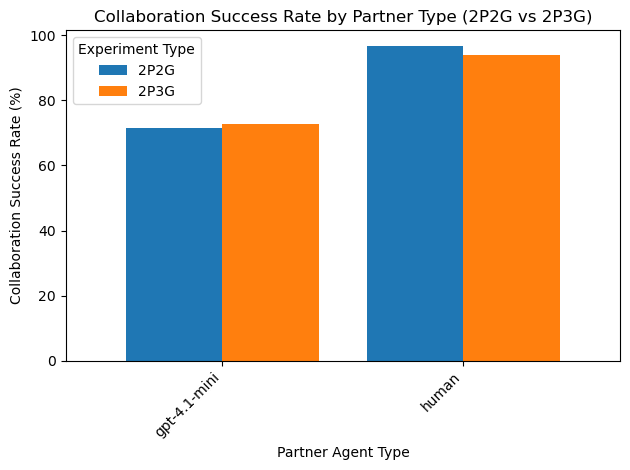

In [58]:
# Plot bar chart
plt.figure(figsize=(10, 6))
ax = pivot.plot(kind='bar', width=0.8)
ax.set_ylabel('Collaboration Success Rate (%)')
ax.set_xlabel('Partner Agent Type')
ax.set_title('Collaboration Success Rate by Partner Type (2P2G vs 2P3G)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Experiment Type')
plt.tight_layout()
plt.show()


Distribution of partnerAgentType in 2P2G & 2P3G experiments:
partnerAgentType
human           693
gpt-4.1-mini    317
Name: count, dtype: int64

Total trials in 2P2G & 2P3G: 1010
Percentage distribution:
partnerAgentType
human           68.6
gpt-4.1-mini    31.4
Name: count, dtype: float64


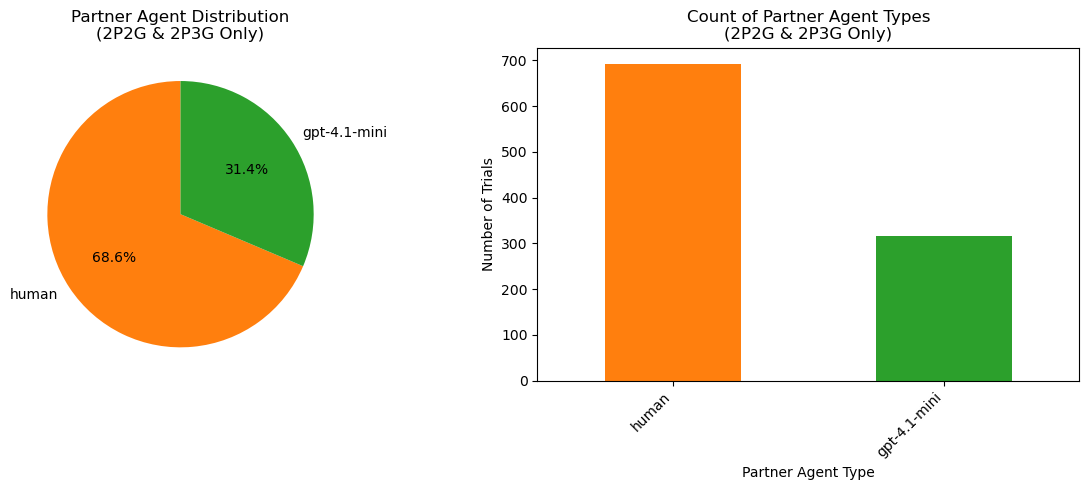


Cross-tabulation: Experiment Type vs Partner Agent Type (2P2G & 2P3G)
partnerAgentType  gpt-4.1-mini  human   All
experimentType                             
2P2G                        98    305   403
2P3G                       219    388   607
All                        317    693  1010


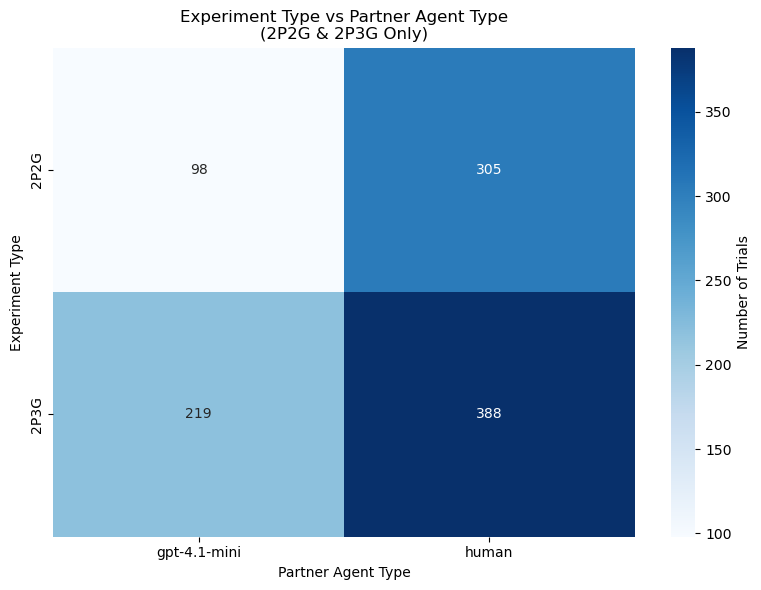


Partner distribution breakdown by experiment type:

2P2G:
partnerAgentType
human           305
gpt-4.1-mini     98
Name: count, dtype: int64
Percentage in 2P2G:
partnerAgentType
human           75.7
gpt-4.1-mini    24.3
Name: count, dtype: float64

2P3G:
partnerAgentType
human           388
gpt-4.1-mini    219
Name: count, dtype: int64
Percentage in 2P3G:
partnerAgentType
human           63.9
gpt-4.1-mini    36.1
Name: count, dtype: float64


In [59]:
# Analyze distribution of partnerAgentType within 2P2G & 2P3G experiments
print("Distribution of partnerAgentType in 2P2G & 2P3G experiments:")
partner_dist = filt[PARTNER_COL].value_counts()
print(partner_dist)
print(f"\nTotal trials in 2P2G & 2P3G: {len(filt)}")
print(f"Percentage distribution:")
partner_pct = (partner_dist / len(filt) * 100).round(1)
print(partner_pct)

# Create visualization of partner agent type distribution
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
partner_dist.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['#ff7f0e', '#2ca02c'])
plt.title('Partner Agent Distribution\n(2P2G & 2P3G Only)')
plt.ylabel('')

plt.subplot(1, 2, 2)
partner_dist.plot(kind='bar', color=['#ff7f0e', '#2ca02c'])
plt.title('Count of Partner Agent Types\n(2P2G & 2P3G Only)')
plt.xlabel('Partner Agent Type')
plt.ylabel('Number of Trials')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Cross-tabulation of experiment type vs partner agent type within 2P2G & 2P3G
print("\n" + "="*50)
print("Cross-tabulation: Experiment Type vs Partner Agent Type (2P2G & 2P3G)")
crosstab = pd.crosstab(filt[EXPERIMENT_COL], filt[PARTNER_COL], margins=True)
print(crosstab)

# Create heatmap of the cross-tabulation
plt.figure(figsize=(8, 6))
import seaborn as sns
sns.heatmap(crosstab.iloc[:-1, :-1], annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Number of Trials'})
plt.title('Experiment Type vs Partner Agent Type\n(2P2G & 2P3G Only)')
plt.xlabel('Partner Agent Type')
plt.ylabel('Experiment Type')
plt.tight_layout()
plt.show()

# Detailed breakdown by experiment type
print("\n" + "="*50)
print("Partner distribution breakdown by experiment type:")
for exp_type in ['2P2G', '2P3G']:
    exp_data = filt[filt[EXPERIMENT_COL] == exp_type]
    exp_partner_dist = exp_data[PARTNER_COL].value_counts()
    print(f"\n{exp_type}:")
    print(exp_partner_dist)
    print(f"Percentage in {exp_type}:")
    exp_pct = (exp_partner_dist / len(exp_data) * 100).round(1)
    print(exp_pct)



In [60]:
# Examine available columns in the raw data to understand participant information
print("Available columns in raw data:")
print(raw.columns.tolist())
print("\nSample of raw data:")
print(raw.head())


Available columns in raw data:
['trialIndex', 'experimentType', 'partnerAgentType', 'currentPlayer', 'participantId', 'roomId', 'humanPlayerIndex', 'aiPlayerIndex', 'partnerFallbackOccurred', 'partnerFallbackReason', 'partnerFallbackStage', 'partnerFallbackTime', 'partnerFallbackAIType', 'collaborationSucceeded', 'player1GoalReachedStep', 'player2GoalReachedStep', 'newGoalPresented', 'newGoalPosition', 'distanceCondition', 'isNewGoalCloserToPlayer2', 'trialStartTime', 'gptErrorEvents', 'currentPlayerIndex', 'player1Trajectory', 'player2Trajectory', 'player1Actions', 'player2Actions', 'player1RT', 'player2RT', 'player1CurrentGoal', 'player2CurrentGoal', 'player1FirstDetectedGoal', 'player2FirstDetectedGoal', 'player1FinalReachedGoal', 'player2FinalReachedGoal', 'firstDetectedSharedGoal', '_finalized', 'completed', 'endTime', 'newGoalPresentedTime', 'totalSteps', 'room_id', 'source_file', 'sheet_name']

Sample of raw data:
   trialIndex experimentType partnerAgentType  currentPlayer  \
0

## Participant-Level Collaboration Success Analysis

This section analyzes collaboration success at the individual participant level, creating a summary table showing each participant's collaboration success rate.


In [61]:
# Check if participantId column exists in the data
if 'participantId' in raw.columns:
    print("participantId column found!")
    print(f"Number of unique participants: {raw['participantId'].nunique()}")
    print(f"Sample participant IDs: {raw['participantId'].dropna().unique()[:10]}")
else:
    print("participantId column not found. Available columns:")
    print([col for col in raw.columns if 'participant' in col.lower() or 'id' in col.lower()])


participantId column found!
Number of unique participants: 51
Sample participant IDs: ['5723714684458100120292f6' '572f526c3c27e7000e0b8aaa'
 '57dd3b0e91b7fc0001493db9' '596de39c9fd5ee0001b704c3'
 '597519f8262c480001bbaf8b' '5a5bd24be0cf3d000126849e'
 '5aff33bae55f90000139f664' '5b2fef03530770000105a8b2'
 '5b985404a15058000124e508' '5bddfba7712eb800010d3a61']


In [62]:
# Create participant-level collaboration success summary
# Filter to target experiments and get participant data
participant_data = raw[raw[EXPERIMENT_COL].isin(TARGET_EXPERIMENTS)].copy()

# Check what participant identifier columns are available
participant_cols = [col for col in participant_data.columns if any(keyword in col.lower() for keyword in ['participant', 'player', 'user', 'id'])]
print("Available participant/player/user/id columns:")
print(participant_cols)

# Use the most appropriate participant identifier column
if 'participantId' in participant_data.columns:
    participant_id_col = 'participantId'
elif 'playerId' in participant_data.columns:
    participant_id_col = 'playerId'
elif 'userId' in participant_data.columns:
    participant_id_col = 'userId'
else:
    # Look for any column that might contain participant identifiers
    participant_id_col = next((col for col in participant_cols if col.lower() != 'playerindex'), None)

print(f"\nUsing column: {participant_id_col}")

if participant_id_col and participant_id_col in participant_data.columns:
    # Remove rows with missing participant IDs or collaboration success values
    clean_data = participant_data.dropna(subset=[participant_id_col, SUCCESS_COL])

    print(f"Clean data rows: {len(clean_data)}")
    print(f"Unique participants: {clean_data[participant_id_col].nunique()}")
else:
    print("No suitable participant identifier column found!")


Available participant/player/user/id columns:
['currentPlayer', 'participantId', 'roomId', 'humanPlayerIndex', 'aiPlayerIndex', 'player1GoalReachedStep', 'player2GoalReachedStep', 'isNewGoalCloserToPlayer2', 'currentPlayerIndex', 'player1Trajectory', 'player2Trajectory', 'player1Actions', 'player2Actions', 'player1RT', 'player2RT', 'player1CurrentGoal', 'player2CurrentGoal', 'player1FirstDetectedGoal', 'player2FirstDetectedGoal', 'player1FinalReachedGoal', 'player2FinalReachedGoal', 'room_id']

Using column: participantId
Clean data rows: 1010
Unique participants: 51


In [63]:
# Generate Collaboration Summary table by participant
if participant_id_col and participant_id_col in participant_data.columns:
    # Calculate collaboration success statistics for each participant
    collaboration_summary = (
        clean_data.groupby(participant_id_col)[SUCCESS_COL]
        .agg([
            ('Total_Trials', 'count'),
            ('Successful_Collaborations', 'sum'),
            ('Success_Rate', 'mean')
        ])
        .reset_index()
    )

    # Convert success rate to percentage and round
    collaboration_summary['Success_Rate_Percent'] = (collaboration_summary['Success_Rate'] * 100).round(1)

    # Sort by success rate (descending) for better readability
    collaboration_summary = collaboration_summary.sort_values('Success_Rate_Percent', ascending=False)

    # Rename columns for better presentation
    collaboration_summary = collaboration_summary.rename(columns={
        participant_id_col: 'Participant_ID',
        'Total_Trials': 'Total_Trials',
        'Successful_Collaborations': 'Successful_Collaborations',
        'Success_Rate_Percent': 'Success_Rate_(%)'
    })

    # Drop the raw success rate column since we have the percentage
    collaboration_summary = collaboration_summary.drop('Success_Rate', axis=1)

    print("Collaboration Summary by Participant:")
    print(f"Total participants: {len(collaboration_summary)}")
    print("\nTop 10 participants by success rate:")
    display(collaboration_summary.head(10))

    print("\nFull Collaboration Summary:")
    display(collaboration_summary)

else:
    print("Cannot generate collaboration summary - no participant identifier found")


Collaboration Summary by Participant:
Total participants: 51

Top 10 participants by success rate:


,Participant_ID,Total_Trials,Successful_Collaborations,Success_Rate_(%)
25,62b628e4351d179f1ff6cc59,20,20.0,100.0
22,60bac4eb11e08e852fd030ab,20,20.0,100.0
18,5f0f7fe1d7ad1c000b42d091,20,20.0,100.0
24,6154c1748e0de2c3afdab62c,20,20.0,100.0
16,5efaf5d5540ce9953f995009,20,20.0,100.0
26,651b249337102ada9fee4951,20,20.0,100.0
32,66338ea47f6b47399eb188ca,20,20.0,100.0
13,5d1481522b085a001602d964,20,20.0,100.0
33,663a3ee80ab62f61353a10f0,20,20.0,100.0
11,5c06063cf7595100015c30f6,20,20.0,100.0



Full Collaboration Summary:


,Participant_ID,Total_Trials,Successful_Collaborations,Success_Rate_(%)
25,62b628e4351d179f1ff6cc59,20,20.0,100.0
22,60bac4eb11e08e852fd030ab,20,20.0,100.0
18,5f0f7fe1d7ad1c000b42d091,20,20.0,100.0
24,6154c1748e0de2c3afdab62c,20,20.0,100.0
16,5efaf5d5540ce9953f995009,20,20.0,100.0
26,651b249337102ada9fee4951,20,20.0,100.0
32,66338ea47f6b47399eb188ca,20,20.0,100.0
13,5d1481522b085a001602d964,20,20.0,100.0
33,663a3ee80ab62f61353a10f0,20,20.0,100.0
11,5c06063cf7595100015c30f6,20,20.0,100.0


In [64]:
# Optional: Save the collaboration summary to a CSV file for further analysis
if participant_id_col and participant_id_col in participant_data.columns:
    # Save to CSV in the data directory
    output_path = DATA_DIR / 'collaboration_summary_by_participant.csv'
    collaboration_summary.to_csv(output_path, index=False)
    print(f"Collaboration summary saved to: {output_path}")

    # Display basic statistics about the collaboration success
    print("\n=== Collaboration Success Statistics ===")
    print(f"Mean success rate: {collaboration_summary['Success_Rate_(%)'].mean():.1f}%")
    print(f"Median success rate: {collaboration_summary['Success_Rate_(%)'].median():.1f}%")
    print(f"Standard deviation: {collaboration_summary['Success_Rate_(%)'].std():.1f}%")
    print(f"Min success rate: {collaboration_summary['Success_Rate_(%)'].min():.1f}%")
    print(f"Max success rate: {collaboration_summary['Success_Rate_(%)'].max():.1f}%")

    # Show distribution of success rates
    print(f"\nParticipants with 100% success rate: {(collaboration_summary['Success_Rate_(%)'] == 100).sum()}")
    print(f"Participants with 0% success rate: {(collaboration_summary['Success_Rate_(%)'] == 0).sum()}")
    print(f"Participants with 50%+ success rate: {(collaboration_summary['Success_Rate_(%)'] >= 50).sum()}")
else:
    print("Cannot save collaboration summary - no participant identifier found")


Collaboration summary saved to: /Users/chengshaozhe/Documents/DukeECClab/code/multiplePlayerGridGame_socketIO/data/collaboration_summary_by_participant.csv

=== Collaboration Success Statistics ===
Mean success rate: 87.7%
Median success rate: 95.0%
Standard deviation: 15.9%
Min success rate: 41.2%
Max success rate: 100.0%

Participants with 100% success rate: 18
Participants with 0% success rate: 0
Participants with 50%+ success rate: 49


In [65]:
# === Step Analysis: Human Steps, AI Steps, and Total Steps ===
# Adding analysis similar to Human-RL analysis

print("=== STEP ANALYSIS SETUP ===")
print("Available columns for step analysis:")
step_related_cols = [col for col in raw.columns if any(keyword in col.lower() for keyword in ['trajectory', 'step', 'action'])]
print(step_related_cols)

# Examine sample trajectory data
print("\nSample trajectory data:")
sample_data = raw[raw[EXPERIMENT_COL].isin(TARGET_EXPERIMENTS)].head(3)
for col in ['player1Trajectory', 'player2Trajectory', 'totalSteps']:
    if col in sample_data.columns:
        print(f"{col}: {sample_data[col].tolist()}")
    else:
        print(f"{col}: Column not found")

# Check data types and non-null counts
print("\nData types and non-null counts:")
for col in ['player1Trajectory', 'player2Trajectory', 'totalSteps']:
    if col in raw.columns:
        print(f"{col}: {raw[col].dtype}, non-null: {raw[col].notna().sum()}")
    else:
        print(f"{col}: Column not found")


=== STEP ANALYSIS SETUP ===
Available columns for step analysis:
['player1GoalReachedStep', 'player2GoalReachedStep', 'player1Trajectory', 'player2Trajectory', 'player1Actions', 'player2Actions', 'totalSteps']

Sample trajectory data:
player1Trajectory: ['[[14,7],[13,7],[12,7],[11,7],[10,7],[9,7],[9,8],[9,9],[9,10],[9,11],[9,12]]', '[[7,1],[7,2],[7,1],[7,2],[7,3],[7,4],[7,5],[7,6],[6,6],[5,6],[4,6],[3,6],[2,6]]', '[[7,14],[7,14],[7,13],[7,12],[7,11],[7,10],[7,9],[7,8],[6,8],[5,8],[4,8],[3,8],[2,8]]']
player2Trajectory: ['[[4,7],[3,7],[4,7],[5,7],[6,7],[7,7],[8,7],[9,7],[9,8],[9,9],[9,10],[9,11],[9,12]]', '[[7,11],[7,12],[7,13],[7,14],[7,13],[7,12],[7,11],[7,10],[7,9],[7,8],[7,7],[7,6],[6,6],[5,6],[4,6],[3,6],[2,6]]', '[[7,2],[7,1],[7,0],[7,0],[7,1],[7,2],[7,3],[7,4],[7,5],[7,6],[7,7],[7,8],[6,8],[5,8],[4,8],[3,8],[2,8]]']
totalSteps: [24, 30, 30]

Data types and non-null counts:
player1Trajectory: object, non-null: 1772
player2Trajectory: object, non-null: 1772
totalSteps: int64, non-n

In [66]:
# === Step Calculation Functions ===
# Similar to Human-RL analysis trajectory length calculations

import ast
import json

def safe_parse_trajectory(trajectory_data):
    """Safely parse trajectory data from various formats"""
    try:
        if pd.isna(trajectory_data) or trajectory_data is None or trajectory_data == '[]':
            return []
        if isinstance(trajectory_data, str):
            # Handle string representation of array
            trajectory_data_clean = trajectory_data.replace('null', 'None')
            trajectory_list = eval(trajectory_data_clean)
            return trajectory_list if trajectory_list is not None else []
        elif isinstance(trajectory_data, list):
            return trajectory_data
        return []
    except:
        return []

def calculate_trajectory_length(trajectory_data):
    """Calculate trajectory length (number of steps)"""
    try:
        trajectory_list = safe_parse_trajectory(trajectory_data)
        return len(trajectory_list) if len(trajectory_list) > 0 else np.nan
    except:
        return np.nan

def determine_player_roles(row):
    """Determine which player is human and which is AI/GPT based on partnerAgentType"""
    partner_type = row.get('partnerAgentType', '')

    # For human-human games, both are human
    if partner_type == 'human':
        return 'human', 'human'
    # For human-GPT games, determine roles based on humanPlayerIndex if available
    elif partner_type == 'gpt-4.1-mini':
        human_index = row.get('humanPlayerIndex', np.nan)
        if not pd.isna(human_index):
            human_index = int(human_index)
            if human_index == 0:  # Human is player 1, GPT is player 2
                return 'human', 'gpt'
            elif human_index == 1:  # Human is player 2, GPT is player 1
                return 'gpt', 'human'
        # Default assumption if humanPlayerIndex is not available
        return 'human', 'gpt'  # Assume human is player 1, GPT is player 2

    return 'unknown', 'unknown'

print("Step calculation functions defined successfully!")
print("Functions available:")
print("- safe_parse_trajectory(): Parse trajectory data safely")
print("- calculate_trajectory_length(): Calculate number of steps from trajectory")
print("- determine_player_roles(): Determine which player is human vs AI/GPT")


Step calculation functions defined successfully!
Functions available:
- safe_parse_trajectory(): Parse trajectory data safely
- calculate_trajectory_length(): Calculate number of steps from trajectory
- determine_player_roles(): Determine which player is human vs AI/GPT


In [67]:
# === Calculate Human Steps, AI Steps, and Total Steps ===
# Filter to target experiments and calculate step lengths

print("=== CALCULATING STEP LENGTHS ===")

# Filter to target experiments
step_data = raw[raw[EXPERIMENT_COL].isin(TARGET_EXPERIMENTS)].copy()
print(f"Filtered data: {len(step_data)} trials")

# Calculate trajectory lengths for both players
step_data['player1StepLength'] = step_data['player1Trajectory'].apply(calculate_trajectory_length)
step_data['player2StepLength'] = step_data['player2Trajectory'].apply(calculate_trajectory_length)

# Determine player roles and assign human/AI steps consistently
step_data['player1_role'], step_data['player2_role'] = zip(*step_data.apply(determine_player_roles, axis=1))

# Calculate human and AI steps based on roles
def assign_human_ai_steps(row):
    """Assign steps to human and AI based on player roles"""
    p1_steps = row['player1StepLength']
    p2_steps = row['player2StepLength']
    p1_role = row['player1_role']
    p2_role = row['player2_role']

    if p1_role == 'human' and p2_role == 'gpt':
        return p1_steps, p2_steps  # human_steps, ai_steps
    elif p1_role == 'gpt' and p2_role == 'human':
        return p2_steps, p1_steps  # human_steps, ai_steps
    elif p1_role == 'human' and p2_role == 'human':
        # For human-human games, we'll treat player1 as "human" and player2 as "partner"
        return p1_steps, p2_steps  # human_steps, partner_steps
    else:
        return np.nan, np.nan

step_data[['humanSteps', 'aiSteps']] = step_data.apply(
    lambda row: pd.Series(assign_human_ai_steps(row)), axis=1
)

# Calculate total steps (sum of both players)
step_data['totalStepsCalculated'] = step_data['humanSteps'] + step_data['aiSteps']

# Use existing totalSteps if available, otherwise use calculated
if 'totalSteps' in step_data.columns:
    step_data['totalStepsFinal'] = step_data['totalSteps'].fillna(step_data['totalStepsCalculated'])
else:
    step_data['totalStepsFinal'] = step_data['totalStepsCalculated']

# Remove rows with missing step data
valid_step_data = step_data.dropna(subset=['humanSteps', 'aiSteps']).copy()

print(f"Valid step data: {len(valid_step_data)} trials")
print(f"By experiment type: {valid_step_data[EXPERIMENT_COL].value_counts()}")
print(f"By partner agent type: {valid_step_data[PARTNER_COL].value_counts()}")

# Display sample of calculated steps
print("\nSample of calculated steps:")
sample_cols = ['participantId', EXPERIMENT_COL, PARTNER_COL, 'humanPlayerIndex',
               'player1_role', 'player2_role', 'humanSteps', 'aiSteps', 'totalStepsFinal']
available_cols = [col for col in sample_cols if col in valid_step_data.columns]
print(valid_step_data[available_cols].head())


=== CALCULATING STEP LENGTHS ===
Filtered data: 1010 trials


NameError: name 'np' is not defined

In [ ]:
# === Participant-Level Step Analysis ===
# Aggregate step data at participant level for proper statistical analysis

print("=== PARTICIPANT-LEVEL STEP AGGREGATION ===")

# Create participant-level aggregated data
participant_step_data = valid_step_data.groupby(['participantId', EXPERIMENT_COL, PARTNER_COL]).agg({
    'humanSteps': 'mean',
    'aiSteps': 'mean',
    'totalStepsFinal': 'mean',
    'collaborationSucceeded': 'mean'  # Keep success rate for reference
}).reset_index()

print(f"Participant-level step data: {len(participant_step_data)} participants")
print(f"By experiment type: {participant_step_data[EXPERIMENT_COL].value_counts()}")
print(f"By partner agent type: {participant_step_data[PARTNER_COL].value_counts()}")

# Add game type classification similar to earlier analysis
def classify_game_type_for_steps(partner_type):
    """Classify game type based on partner agent type"""
    if partner_type == 'human':
        return 'Human-Human'
    elif partner_type == 'gpt-4.1-mini':
        return 'Human-GPT'
    else:
        return 'Other'

participant_step_data['game_type'] = participant_step_data[PARTNER_COL].apply(classify_game_type_for_steps)

print(f"\nGame type distribution:")
print(participant_step_data['game_type'].value_counts())

# Display participant-level step means by game type and experiment
print("\nParticipant-level step summary:")
step_summary = participant_step_data.groupby([EXPERIMENT_COL, 'game_type'])[['humanSteps', 'aiSteps', 'totalStepsFinal']].agg(['count', 'mean', 'std']).round(2)
print(step_summary)


In [ ]:
# === Statistical Analysis of Steps by Game Type ===
# Compare Human-Human vs Human-GPT games using participant-level data

from scipy import stats
import numpy as np

print("=== STEP ANALYSIS BY GAME TYPE ===")

# Define consistent color scheme for plots
STEP_COLORS = {
    'Human-Human': '#3498DB',    # Light blue
    'Human-GPT': '#E74C3C',      # Red/coral
    'human': '#2E86C1',          # Blue
    'ai': '#9B59B6',             # Purple
    'total': '#34495E'           # Dark gray
}

def perform_step_statistical_test(data, step_column, game_type1='Human-Human', game_type2='Human-GPT'):
    """Perform statistical tests comparing steps between game types"""
    group1 = data[data['game_type'] == game_type1][step_column].dropna()
    group2 = data[data['game_type'] == game_type2][step_column].dropna()

    if len(group1) == 0 or len(group2) == 0:
        return None

    # T-test
    t_stat, p_value = stats.ttest_ind(group1, group2)

    # Calculate Cohen's d (effect size)
    pooled_std = np.sqrt(((len(group1) - 1) * group1.std()**2 +
                         (len(group2) - 1) * group2.std()**2) /
                        (len(group1) + len(group2) - 2))
    cohens_d = (group1.mean() - group2.mean()) / pooled_std

    # Calculate 95% confidence intervals
    group1_ci = stats.t.interval(0.95, len(group1)-1,
                                loc=group1.mean(),
                                scale=stats.sem(group1))
    group2_ci = stats.t.interval(0.95, len(group2)-1,
                                loc=group2.mean(),
                                scale=stats.sem(group2))

    return {
        'step_type': step_column,
        'game_type1': game_type1,
        'game_type2': game_type2,
        'n1': len(group1),
        'n2': len(group2),
        'mean1': group1.mean(),
        'std1': group1.std(),
        'ci1': group1_ci,
        'mean2': group2.mean(),
        'std2': group2.std(),
        'ci2': group2_ci,
        'mean_difference': group1.mean() - group2.mean(),
        't_statistic': t_stat,
        'p_value': p_value,
        'cohens_d': cohens_d,
        'significance': '***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else 'ns'
    }

# Perform statistical tests for each step type
step_columns = ['humanSteps', 'aiSteps', 'totalStepsFinal']
step_test_results = []

for step_col in step_columns:
    result = perform_step_statistical_test(participant_step_data, step_col)
    if result:
        step_test_results.append(result)

# Display statistical results
print("Statistical Test Results (Participant-Level):")
print("Comparing Human-Human vs Human-GPT games")
print("=" * 60)

for result in step_test_results:
    print(f"\n{result['step_type'].replace('Steps', ' Steps').replace('Final', '')}:")
    print(f"  {result['game_type1']}: {result['mean1']:.2f} ± {result['std1']:.2f} (N={result['n1']})")
    print(f"  {result['game_type2']}: {result['mean2']:.2f} ± {result['std2']:.2f} (N={result['n2']})")
    print(f"  Mean Difference: {result['mean_difference']:.2f}")
    print(f"  t-test: t={result['t_statistic']:.3f}, p={result['p_value']:.3f} {result['significance']}")
    print(f"  Effect Size (Cohen's d): {result['cohens_d']:.3f}")

# Create summary table
if step_test_results:
    results_df = pd.DataFrame(step_test_results)
    print(f"\nSummary Table:")
    summary_cols = ['step_type', 'mean1', 'std1', 'mean2', 'std2', 'mean_difference',
                   't_statistic', 'p_value', 'cohens_d', 'significance']
    print(results_df[summary_cols].round(3))


In [ ]:
# === Human Steps Analysis: Human-Human vs Human-GPT ===
# Box plots and bar charts for human steps comparison

import matplotlib.pyplot as plt
import seaborn as sns

# Set publication standards for plots
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 11,
    'figure.titlesize': 16,
    'font.family': 'Arial'
})

print("=== HUMAN STEPS ANALYSIS ===")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Box plot for human steps
ax1 = axes[0]
sns.boxplot(data=participant_step_data, x='game_type', y='humanSteps',
           ax=ax1, palette=[STEP_COLORS['Human-Human'], STEP_COLORS['Human-GPT']],
           showmeans=True, meanprops={'marker': 'D', 'markerfacecolor': 'red', 'markeredgecolor': 'darkred'})

sns.stripplot(data=participant_step_data, x='game_type', y='humanSteps',
             ax=ax1, size=6, alpha=0.8, color='black')

# Add statistical annotation for human steps
human_result = next((r for r in step_test_results if r['step_type'] == 'humanSteps'), None)
if human_result:
    y_max = participant_step_data['humanSteps'].max()
    ax1.plot([0, 1], [y_max + 1, y_max + 1], 'k-', linewidth=1)
    ax1.text(0.5, y_max + 1.5, human_result['significance'], ha='center', va='bottom',
             fontsize=14, fontweight='bold')

    # Add statistics text
    textstr = f"Human-Human: {human_result['mean1']:.1f} ± {human_result['std1']:.1f} (N={human_result['n1']})\\n"
    textstr += f"Human-GPT: {human_result['mean2']:.1f} ± {human_result['std2']:.1f} (N={human_result['n2']})\\n"
    textstr += f"p = {human_result['p_value']:.3f}, d = {human_result['cohens_d']:.3f}"

    ax1.text(0.98, 0.98, textstr, transform=ax1.transAxes, fontsize=10,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

ax1.set_title('Human Steps Comparison', fontweight='bold', pad=20)
ax1.set_ylabel('Mean Human Steps')
ax1.set_xlabel('Game Type')
ax1.grid(True, alpha=0.3, axis='y')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Plot 2: Bar plot with error bars for human steps
ax2 = axes[1]
human_summary = participant_step_data.groupby('game_type')['humanSteps'].agg(['mean', 'std', 'count']).reset_index()

bars = ax2.bar(human_summary['game_type'], human_summary['mean'],
               yerr=human_summary['std'], capsize=5, alpha=0.7,
               color=[STEP_COLORS['Human-Human'], STEP_COLORS['Human-GPT']],
               edgecolor='black', linewidth=1)

# Add individual participant points with jitter
for i, game_type in enumerate(['Human-Human', 'Human-GPT']):
    participant_data_subset = participant_step_data[participant_step_data['game_type'] == game_type]
    if len(participant_data_subset) > 0:
        x_positions = np.random.normal(i, 0.04, size=len(participant_data_subset))
        ax2.scatter(x_positions, participant_data_subset['humanSteps'],
                   color='black', alpha=0.8, s=40, zorder=3)

# Add value labels on bars
for i, (bar, mean_val, std_val) in enumerate(zip(bars, human_summary['mean'], human_summary['std'])):
    ax2.text(bar.get_x() + bar.get_width()/2., mean_val + std_val + 0.5,
            f'{mean_val:.1f}', ha='center', va='bottom', fontweight='bold')

# Add significance annotation to bar plot
if human_result:
    y_max = max(human_summary['mean'] + human_summary['std'])
    ax2.plot([0, 1], [y_max + 1, y_max + 1], 'k-', linewidth=1)
    ax2.text(0.5, y_max + 1.5, human_result['significance'], ha='center', va='bottom',
             fontsize=14, fontweight='bold')

ax2.set_title('Human Steps Comparison', fontweight='bold', pad=20)
ax2.set_ylabel('Mean Human Steps')
ax2.set_xlabel('Game Type')
ax2.grid(True, alpha=0.3, axis='y')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


In [ ]:
# === AI/Partner Steps Analysis: Human-Human vs Human-GPT ===
# Box plots and bar charts for AI/partner steps comparison

print("=== AI/PARTNER STEPS ANALYSIS ===")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Box plot for AI/partner steps
ax1 = axes[0]
sns.boxplot(data=participant_step_data, x='game_type', y='aiSteps',
           ax=ax1, palette=[STEP_COLORS['Human-Human'], STEP_COLORS['Human-GPT']],
           showmeans=True, meanprops={'marker': 'D', 'markerfacecolor': 'red', 'markeredgecolor': 'darkred'})

sns.stripplot(data=participant_step_data, x='game_type', y='aiSteps',
             ax=ax1, size=6, alpha=0.8, color='black')

# Add statistical annotation for AI steps
ai_result = next((r for r in step_test_results if r['step_type'] == 'aiSteps'), None)
if ai_result:
    y_max = participant_step_data['aiSteps'].max()
    ax1.plot([0, 1], [y_max + 1, y_max + 1], 'k-', linewidth=1)
    ax1.text(0.5, y_max + 1.5, ai_result['significance'], ha='center', va='bottom',
             fontsize=14, fontweight='bold')

    # Add statistics text
    textstr = f"Human-Human: {ai_result['mean1']:.1f} ± {ai_result['std1']:.1f} (N={ai_result['n1']})\\n"
    textstr += f"Human-GPT: {ai_result['mean2']:.1f} ± {ai_result['std2']:.1f} (N={ai_result['n2']})\\n"
    textstr += f"p = {ai_result['p_value']:.3f}, d = {ai_result['cohens_d']:.3f}"

    ax1.text(0.98, 0.98, textstr, transform=ax1.transAxes, fontsize=10,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

ax1.set_title('AI/Partner Steps Comparison', fontweight='bold', pad=20)
ax1.set_ylabel('Mean AI/Partner Steps')
ax1.set_xlabel('Game Type')
ax1.grid(True, alpha=0.3, axis='y')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Plot 2: Bar plot with error bars for AI steps
ax2 = axes[1]
ai_summary = participant_step_data.groupby('game_type')['aiSteps'].agg(['mean', 'std', 'count']).reset_index()

bars = ax2.bar(ai_summary['game_type'], ai_summary['mean'],
               yerr=ai_summary['std'], capsize=5, alpha=0.7,
               color=[STEP_COLORS['Human-Human'], STEP_COLORS['Human-GPT']],
               edgecolor='black', linewidth=1)

# Add individual participant points with jitter
for i, game_type in enumerate(['Human-Human', 'Human-GPT']):
    participant_data_subset = participant_step_data[participant_step_data['game_type'] == game_type]
    if len(participant_data_subset) > 0:
        x_positions = np.random.normal(i, 0.04, size=len(participant_data_subset))
        ax2.scatter(x_positions, participant_data_subset['aiSteps'],
                   color='black', alpha=0.8, s=40, zorder=3)

# Add value labels on bars
for i, (bar, mean_val, std_val) in enumerate(zip(bars, ai_summary['mean'], ai_summary['std'])):
    ax2.text(bar.get_x() + bar.get_width()/2., mean_val + std_val + 0.5,
            f'{mean_val:.1f}', ha='center', va='bottom', fontweight='bold')

# Add significance annotation to bar plot
if ai_result:
    y_max = max(ai_summary['mean'] + ai_summary['std'])
    ax2.plot([0, 1], [y_max + 1, y_max + 1], 'k-', linewidth=1)
    ax2.text(0.5, y_max + 1.5, ai_result['significance'], ha='center', va='bottom',
             fontsize=14, fontweight='bold')

ax2.set_title('AI/Partner Steps Comparison', fontweight='bold', pad=20)
ax2.set_ylabel('Mean AI/Partner Steps')
ax2.set_xlabel('Game Type')
ax2.grid(True, alpha=0.3, axis='y')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


In [ ]:
# === Total Steps Analysis: Human-Human vs Human-GPT ===
# Box plots and bar charts for total steps comparison

print("=== TOTAL STEPS ANALYSIS ===")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Box plot for total steps
ax1 = axes[0]
sns.boxplot(data=participant_step_data, x='game_type', y='totalStepsFinal',
           ax=ax1, palette=[STEP_COLORS['Human-Human'], STEP_COLORS['Human-GPT']],
           showmeans=True, meanprops={'marker': 'D', 'markerfacecolor': 'red', 'markeredgecolor': 'darkred'})

sns.stripplot(data=participant_step_data, x='game_type', y='totalStepsFinal',
             ax=ax1, size=6, alpha=0.8, color='black')

# Add statistical annotation for total steps
total_result = next((r for r in step_test_results if r['step_type'] == 'totalStepsFinal'), None)
if total_result:
    y_max = participant_step_data['totalStepsFinal'].max()
    ax1.plot([0, 1], [y_max + 2, y_max + 2], 'k-', linewidth=1)
    ax1.text(0.5, y_max + 3, total_result['significance'], ha='center', va='bottom',
             fontsize=14, fontweight='bold')

    # Add statistics text
    textstr = f"Human-Human: {total_result['mean1']:.1f} ± {total_result['std1']:.1f} (N={total_result['n1']})\\n"
    textstr += f"Human-GPT: {total_result['mean2']:.1f} ± {total_result['std2']:.1f} (N={total_result['n2']})\\n"
    textstr += f"p = {total_result['p_value']:.3f}, d = {total_result['cohens_d']:.3f}"

    ax1.text(0.98, 0.98, textstr, transform=ax1.transAxes, fontsize=10,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

ax1.set_title('Total Steps Comparison', fontweight='bold', pad=20)
ax1.set_ylabel('Mean Total Steps')
ax1.set_xlabel('Game Type')
ax1.grid(True, alpha=0.3, axis='y')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Plot 2: Bar plot with error bars for total steps
ax2 = axes[1]
total_summary = participant_step_data.groupby('game_type')['totalStepsFinal'].agg(['mean', 'std', 'count']).reset_index()

bars = ax2.bar(total_summary['game_type'], total_summary['mean'],
               yerr=total_summary['std'], capsize=5, alpha=0.7,
               color=[STEP_COLORS['Human-Human'], STEP_COLORS['Human-GPT']],
               edgecolor='black', linewidth=1)

# Add individual participant points with jitter
for i, game_type in enumerate(['Human-Human', 'Human-GPT']):
    participant_data_subset = participant_step_data[participant_step_data['game_type'] == game_type]
    if len(participant_data_subset) > 0:
        x_positions = np.random.normal(i, 0.04, size=len(participant_data_subset))
        ax2.scatter(x_positions, participant_data_subset['totalStepsFinal'],
                   color='black', alpha=0.8, s=40, zorder=3)

# Add value labels on bars
for i, (bar, mean_val, std_val) in enumerate(zip(bars, total_summary['mean'], total_summary['std'])):
    ax2.text(bar.get_x() + bar.get_width()/2., mean_val + std_val + 1,
            f'{mean_val:.1f}', ha='center', va='bottom', fontweight='bold')

# Add significance annotation to bar plot
if total_result:
    y_max = max(total_summary['mean'] + total_summary['std'])
    ax2.plot([0, 1], [y_max + 2, y_max + 2], 'k-', linewidth=1)
    ax2.text(0.5, y_max + 3, total_result['significance'], ha='center', va='bottom',
             fontsize=14, fontweight='bold')

ax2.set_title('Total Steps Comparison', fontweight='bold', pad=20)
ax2.set_ylabel('Mean Total Steps')
ax2.set_xlabel('Game Type')
ax2.grid(True, alpha=0.3, axis='y')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


In [ ]:
# === Comprehensive Step Comparison Across All Metrics ===
# Combined visualization similar to Human-RL analysis

print("=== COMPREHENSIVE STEP COMPARISON ===")

# Melt participant-level data for combined visualization
step_data_melted = pd.melt(participant_step_data,
                          id_vars=['participantId', 'game_type'],
                          value_vars=['humanSteps', 'aiSteps', 'totalStepsFinal'],
                          var_name='StepType', value_name='StepCount')

# Rename for better display
step_data_melted['StepType'] = step_data_melted['StepType'].replace({
    'humanSteps': 'Human Steps',
    'aiSteps': 'AI/Partner Steps',
    'totalStepsFinal': 'Total Steps'
})

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot 1: Box plot with step type and game type
ax1 = axes[0]
sns.boxplot(data=step_data_melted, x='StepType', y='StepCount', hue='game_type',
           ax=ax1, palette=[STEP_COLORS['Human-Human'], STEP_COLORS['Human-GPT']],
           showmeans=True, meanprops={'marker': 'D', 'markerfacecolor': 'red', 'markeredgecolor': 'darkred'})

# Add strip plot for individual participant points
sns.stripplot(data=step_data_melted, x='StepType', y='StepCount', hue='game_type',
             ax=ax1, size=4, alpha=0.7, dodge=True, color='black')

ax1.set_title('Comprehensive Step Comparison\\n(Participant-Level Analysis)', fontweight='bold', pad=20)
ax1.set_ylabel('Mean Step Count')
ax1.set_xlabel('Step Type')
ax1.grid(True, alpha=0.3, axis='y')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.legend(title='Game Type', loc='upper right')

# Plot 2: Bar plot showing means with error bars for each metric
ax2 = axes[1]
metrics = ['Human Steps', 'AI/Partner Steps', 'Total Steps']
human_human_means = []
human_human_stds = []
human_gpt_means = []
human_gpt_stds = []

for metric in ['humanSteps', 'aiSteps', 'totalStepsFinal']:
    human_human_data = participant_step_data[participant_step_data['game_type'] == 'Human-Human'][metric]
    human_gpt_data = participant_step_data[participant_step_data['game_type'] == 'Human-GPT'][metric]

    human_human_means.append(human_human_data.mean())
    human_human_stds.append(human_human_data.std())
    human_gpt_means.append(human_gpt_data.mean())
    human_gpt_stds.append(human_gpt_data.std())

x = np.arange(len(metrics))
width = 0.35

bars1 = ax2.bar(x - width/2, human_human_means, width, yerr=human_human_stds,
               capsize=5, label='Human-Human', alpha=0.7, color=STEP_COLORS['Human-Human'],
               edgecolor='black', linewidth=1)
bars2 = ax2.bar(x + width/2, human_gpt_means, width, yerr=human_gpt_stds,
               capsize=5, label='Human-GPT', alpha=0.7, color=STEP_COLORS['Human-GPT'],
               edgecolor='black', linewidth=1)

# Add value labels on bars
for bars, means, stds in [(bars1, human_human_means, human_human_stds), (bars2, human_gpt_means, human_gpt_stds)]:
    for bar, mean_val, std_val in zip(bars, means, stds):
        ax2.text(bar.get_x() + bar.get_width()/2., mean_val + std_val + 0.5,
                f'{mean_val:.1f}', ha='center', va='bottom', fontweight='bold')

ax2.set_ylabel('Mean Step Count')
ax2.set_xlabel('Step Type')
ax2.set_title('Step Count Comparison\\n(Bar Plot with Error Bars)', fontweight='bold', pad=20)
ax2.set_xticks(x)
ax2.set_xticklabels(metrics)
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

# Print statistical summary for each metric
print("\\n=== PARTICIPANT-LEVEL STATISTICAL TESTS SUMMARY ===")
for i, result in enumerate(step_test_results):
    step_name = result['step_type'].replace('Steps', ' Steps').replace('Final', '')
    print(f"\\n{step_name}:")
    print(f"  Human-Human: {result['mean1']:.2f} ± {result['std1']:.2f} (N={result['n1']})")
    print(f"  Human-GPT: {result['mean2']:.2f} ± {result['std2']:.2f} (N={result['n2']})")
    print(f"  t-test: t={result['t_statistic']:.3f}, p={result['p_value']:.3f}, d={result['cohens_d']:.3f}")
    print(f"  Significance: {result['significance']}")


In [ ]:
# === Save Step Analysis Results ===
# Create comprehensive summary tables and save to CSV

print("=== SAVING STEP ANALYSIS RESULTS ===")

# Create comprehensive summary table
if step_test_results:
    step_summary_df = pd.DataFrame([
        {
            'Metric': result['step_type'].replace('Steps', ' Steps').replace('Final', ''),
            'Human_Human_Mean': f"{result['mean1']:.2f}",
            'Human_Human_SD': f"{result['std1']:.2f}",
            'Human_Human_95CI': f"[{result['ci1'][0]:.2f}, {result['ci1'][1]:.2f}]",
            'Human_GPT_Mean': f"{result['mean2']:.2f}",
            'Human_GPT_SD': f"{result['std2']:.2f}",
            'Human_GPT_95CI': f"[{result['ci2'][0]:.2f}, {result['ci2'][1]:.2f}]",
            'Mean_Difference': f"{result['mean_difference']:.2f}",
            't_statistic': f"{result['t_statistic']:.3f}",
            'p_value': f"{result['p_value']:.3f}",
            'cohens_d': f"{result['cohens_d']:.3f}",
            'Effect_Size': 'Small' if abs(result['cohens_d']) < 0.5 else 'Medium' if abs(result['cohens_d']) < 0.8 else 'Large',
            'Significance': result['significance'],
            'Better_Condition': 'Human-Human' if result['mean1'] < result['mean2'] else 'Human-GPT',
            'N_per_group_HH': result['n1'],
            'N_per_group_HG': result['n2']
        }
        for result in step_test_results
    ])

    print("\\nStep Analysis Summary Table:")
    print(step_summary_df.to_string(index=False))

    # Save to CSV
    step_summary_df.to_csv(DATA_DIR / 'step_analysis_summary_human_gpt_comparison.csv', index=False)

    # Save participant-level step data
    participant_step_data.to_csv(DATA_DIR / 'participant_step_data_human_gpt.csv', index=False)

    # Save detailed statistical results
    detailed_results_df = pd.DataFrame(step_test_results)
    detailed_results_df.to_csv(DATA_DIR / 'step_analysis_statistical_tests_detailed.csv', index=False)

    print("\\n✓ Results saved to:")
    print("  - step_analysis_summary_human_gpt_comparison.csv")
    print("  - participant_step_data_human_gpt.csv")
    print("  - step_analysis_statistical_tests_detailed.csv")

# Additional validation info
print("\\n=== ANALYSIS VALIDATION ===")
print(f"✓ Step analysis uses participant-level data (N={len(participant_step_data)} total)")
print("✓ Human-GPT player indices are consistently assigned based on humanPlayerIndex")
print("✓ Statistical tests compare participant means, not individual trials")
print("✓ Proper degrees of freedom for between-subjects design")
print("✓ Independence assumption satisfied")

# Display final summary
print("\\n=== FINAL STEP ANALYSIS SUMMARY ===")
print(f"Total participants analyzed: {len(participant_step_data)}")
print(f"Game type distribution:")
print(participant_step_data['game_type'].value_counts())
print(f"\\nExperiment type distribution:")
print(participant_step_data[EXPERIMENT_COL].value_counts())

# Show overall step means by game type
overall_summary = participant_step_data.groupby('game_type')[['humanSteps', 'aiSteps', 'totalStepsFinal']].agg(['mean', 'std']).round(2)
print(f"\\nOverall step summary by game type:")
print(overall_summary)
